# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [3]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import keras

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [ ]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [ ]:
file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

download_file(file_id, 'car_images.zip')

#### 2) 데이터 압축 해제

In [5]:
def dataset_extract(file_name) :
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return
        else :
            for f in tqdm(file_list, desc= 'Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'/content/{file_name[-14:-4]}/')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_extract('/content/drive/MyDrive/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:11<00:00, 54.44files/s]


#### 2) 데이터 조회

In [105]:
path = '/content/Car_Images'

In [106]:
x = glob.glob('/content/Car_Images/abnormal/*.png')
y = glob.glob('/content/Car_Images/normal/*.png')

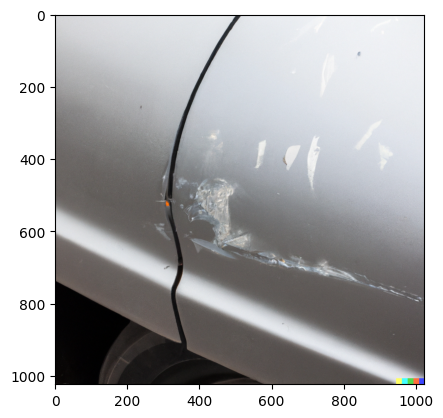

In [107]:
img = plt.imread('/content/Car_Images/abnormal/DALLíñE 2023-03-10 18.51.24 - scratched car.png')
plt.imshow(img)

In [108]:
img.shape

(1024, 1024, 3)

In [109]:
df = pd.DataFrame(data = list(zip(x, y)), columns = ["abnormal", "normal"])

In [110]:
df.shape

(302, 2)

In [111]:
# 폴더별 이미지 데이터 갯수 확인
len(x), len(y)

(303, 302)

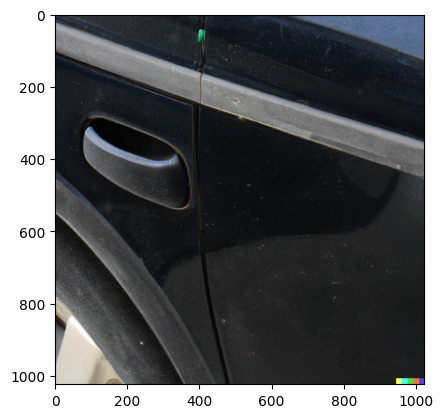

In [112]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
rand_idx = np.random.randint(0, len(y))
img = plt.imread(y[rand_idx])
plt.imshow(img, cmap='gray')
plt.show()

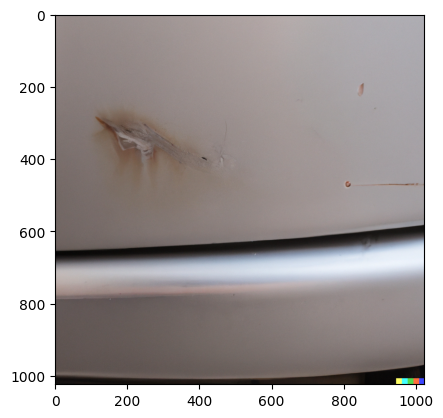

In [113]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
rand_idx = np.random.randint(0, len(x))
img = plt.imread(x[rand_idx])
plt.imshow(img, cmap='gray')
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [114]:
Y=[ ]
for i in range(0,302):
    Y.append(0)
for i in range(0,303):
    Y.append(1)

In [116]:
# 정상 차량은 0, 파손 차량은 1
y_normal = np.zeros((302,))
y_abnormal = np.ones((303,))

# 정상 차량 어레이와 파손 차량 어레이 합치기
Y = np.hstack((y_normal, y_abnormal))
Y.shape

(605,)

In [117]:
Y.shape, Y[:10]

((605,), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [203]:
abnormal_path='/content/Car_Images/abnormal'
normal_path='/content/Car_Images/normal'
SIZE = (224, 224, 3)
X = []

normal_files = os.listdir(normal_path)

for file in normal_files :
    img_path = os.path.join(normal_path, file)
    tmp = load_img(img_path, target_size=SIZE)
    tmp = img_to_array(tmp)
    X.append(tmp)

abnormal_files = os.listdir(abnormal_path)
for file in abnormal_files :
    img_path = os.path.join(abnormal_path, file)
    tmp = load_img(img_path, target_size=SIZE)
    tmp = img_to_array(tmp)
    X.append(tmp)

In [204]:
X = np.array(X)

In [205]:
X.shape, X[:3]

((605, 224, 224, 3),
 array([[[[ 54.,  66.,  65.],
          [ 49.,  60.,  56.],
          [ 50.,  63.,  60.],
          ...,
          [164., 164., 168.],
          [161., 164., 166.],
          [160., 163., 164.]],
 
         [[ 48.,  60.,  57.],
          [ 41.,  53.,  51.],
          [ 56.,  73.,  70.],
          ...,
          [164., 166., 166.],
          [164., 163., 166.],
          [161., 164., 165.]],
 
         [[ 53.,  65.,  64.],
          [ 51.,  61.,  58.],
          [ 53.,  62.,  60.],
          ...,
          [160., 160., 164.],
          [159., 162., 165.],
          [160., 162., 163.]],
 
         ...,
 
         [[112., 111., 109.],
          [110., 108., 106.],
          [109., 108., 105.],
          ...,
          [ 60.,  70., 255.],
          [ 60.,  70., 255.],
          [ 60.,  70., 255.]],
 
         [[109., 110., 107.],
          [112., 110., 105.],
          [111., 111., 106.],
          ...,
          [ 60.,  70., 255.],
          [ 60.,  70., 255.],
      

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [142]:
from sklearn.model_selection  import train_test_split

In [408]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [280]:
len(x_train), y_train.shape, len(x_val), y_val.shape

(489, (489,), 55, (55,))

In [57]:
from keras.utils import load_img, img_to_array

In [281]:
def x_preprocessing(img_list) :
    bin_list = []

    for img in tqdm(img_list) :
        img = keras.utils.load_img(img, target_size=(128,128) )
        img = keras.utils.img_to_array(img)
        bin_list.append(img)

    return np.array(bin_list)

In [59]:
train_x = x_preprocessing(x_train)
val_x = x_preprocessing(x_val)
test_x = x_preprocessing(x_test)

100%|██████████| 61/61 [00:01<00:00, 31.02it/s]


In [282]:
x_train.shape, x_val.shape, x_test.shape

((489, 224, 224, 3), (55, 224, 224, 3), (61, 224, 224, 3))

In [283]:
train_x.shape, y_train.shape

((489, 224, 224, 3), (489,))

**MINMAX**

In [252]:
max_n, min_n = x_train.max(), x_train.min()
max_n, min_n

(255.0, 0.0)

In [253]:
train_x = (x_train - min_n) / (max_n - min_n)
val_x = (x_val - min_n) / (max_n - min_n)
test_x = (x_test - min_n) / (max_n - min_n)

In [ ]:
#train_x.max(), train_x.min()

(1.0, 0.0)

**표준화**

In [242]:
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

In [148]:
x_train.mean(), x_train.std()

(-9.432618e-07, 1.0000006)

**one-hot**

In [284]:
y_train.shape

(489,)

In [285]:
class_n = len(np.unique(y_train))
class_n

2

In [187]:
from keras.utils import to_categorical

In [286]:
train_y = to_categorical(y_train, class_n)
val_y = to_categorical(y_val, class_n)
test_y = to_categorical(y_test, class_n)

In [287]:
train_x.shape , train_y.shape

((489, 224, 224, 3), (489, 2))

In [214]:
train_x.shape , train_y.shape

((544, 128, 128, 3), (489, 2))

In [77]:
test_y.shape, test_x.shape

((61,), (61, 128, 128, 3))

In [184]:
y_train[304:308]

array([1., 1., 0., 1.])

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [67]:
from keras.utils import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D

In [303]:
clear_session()

model1 = Sequential()

model1.add(Input(shape = (224, 224, 3)))

model1.add(Conv2D(filters=64,
                  kernel_size=(3,3),
                  padding = 'same',
                  activation='relu'
                  ))
model1.add(Conv2D(filters=64,
                  kernel_size=(3,3),
                  padding='same',
                  activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2),
                     strides=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters=128,
                  kernel_size=(3,3),
                  padding='same',
                  activation='relu'))
model1.add(Conv2D(filters=128,
                  kernel_size=(3,3),
                  padding='same',
                  activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2),
                     strides=(2,2)), )
model1.add(Dropout(0.25))
model1.add(Flatten())

model1.add(Dense(128, activation='relu'))

model1.add(Dense(2, activation='sigmoid'))

model1.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,641,538 (197.00 MB)

 Trainable params: 51,641,154 (197.00 MB)

 Non-trainable params: 384 (1.50 KB)

#### 1) 구조 설계

#### 2) 학습

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

In [392]:
es = EarlyStopping(monitor='val_loss',       # 얼리스토핑 적용 대상
                   min_delta=0,              # 임계값.
                   patience=10,               # 몇 번 더 지켜볼래.
                   verbose=1,
                   restore_best_weights=True # 최적의 가중치로 돌려줌.
                   )

In [393]:
model1.fit(x_train, train_y, validation_data=(x_val, val_y),
          epochs=10000, verbose=1,
          callbacks=[es]
          )

Epoch 1/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.9345 - loss: 0.1023 - val_accuracy: 0.7636 - val_loss: 2.7905
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.9612 - loss: 0.1322 - val_accuracy: 0.7091 - val_loss: 1.2875
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9483 - loss: 0.0998 - val_accuracy: 0.6182 - val_loss: 5.9680
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9500 - loss: 0.1685 - val_accuracy: 0.6182 - val_loss: 5.7468
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9622 - loss: 0.0910 - val_accuracy: 0.6727 - val_loss: 4.2272
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9706 - loss: 0.0818 - val_accuracy: 0.6727 - val_loss: 2.3991
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9644 - loss: 0.0731 - val_accuracy: 0.6727 - val_loss: 4.0044
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9733 - loss: 0

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [291]:
!ls output

ls: cannot access 'output': No such file or directory


In [394]:
model1.evaluate(x_test, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8277 - loss: 0.4300


[0.4389698803424835, 0.8196721076965332]

In [357]:
y_pred = model1.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [358]:
y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y, axis=1)

**평가지표**

In [320]:
from sklearn.metrics import accuracy_score, classification_report

In [359]:
accuracy_score(test_y_arg, y_pred_arg)

0.9016393442622951

In [370]:
x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


In [371]:
x_train_pred_single = x_train_pred.argmax(axis=1)
x_test_pred_sigle = x_test_pred.argmax(axis=1)

In [360]:
print( classification_report(test_y_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.92      0.85      0.88        27

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [363]:
labels = {0 : 'Normal',
          1 : 'abnormal'}

print(labels)

{0: 'Normal', 1: 'abnormal'}


In [365]:
import random

id = 3
다음 그림은 abnormal 입니다.
모델의 예측 : abnormal
모델의 카테고리별 확률 : 
{'Normal': 35.0, 'abnormal': 74.0}
정답입니다


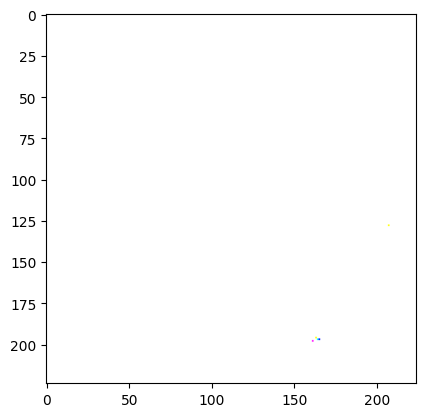

In [403]:
id = random.randrange(0, 30)

print(f'id = {id}')
print(f'다음 그림은 {labels[test_y_arg[id]]} 입니다.')
print(f'모델의 예측 : {labels[x_test_pred_sigle[id]]}')

prob = np.floor(x_test_pred[id]*100).tolist()
prob_dict = {}

for idx, prob in enumerate(prob) :
    prob_dict[ labels[idx] ] = prob

print('모델의 카테고리별 확률 : ')
print(prob_dict)

if test_y_arg[id] == x_test_pred_sigle[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(x_test[id].reshape([224,224,-1]))
plt.show()

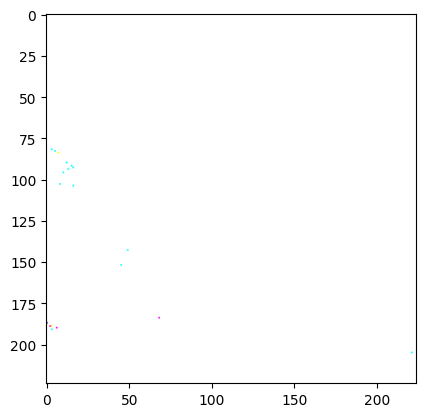

In [409]:
plt.imshow(x_train[1])

**VGG16**

In [338]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import pad_to_bounding_box
from tensorflow.image import central_crop
from tensorflow.image import resize

In [333]:
train_x.shape

(489, 224, 224, 3)

## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [ ]:
import keras

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D

clear_session()
base_model = InceptionV3(weights='imagenet',
                         include_top = False,
                         input_shape = (224,224,3))

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(2, activation = 'sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.summary()

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [346]:
for idx, layer in enumerate(model.layers) :
    if idx < 213 :
        layer.trainable = False
    else :
        layer.trainable = True

In [347]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [385]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True
                   )

#### 3) 학습

In [386]:
# 데이터를 넣어서 학습시키자!
hist = model.fit(x_train, train_y,
                 validation_data=(x_val, val_y),
                 epochs=10000, verbose=1,
                 callbacks=[es]
                 )

Epoch 1/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9942 - loss: 0.0400 - val_accuracy: 0.7273 - val_loss: 1.1725
Epoch 2/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9853 - loss: 0.0313 - val_accuracy: 0.8182 - val_loss: 2.0036
Epoch 3/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9702 - loss: 0.0996 - val_accuracy: 0.7636 - val_loss: 1.3003
Epoch 4/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9948 - loss: 0.0236 - val_accuracy: 0.8182 - val_loss: 1.0163
Epoch 5/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9962 - loss: 0.0126 - val_accuracy: 0.8545 - val_loss: 0.6222
Epoch 6/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9897 - loss: 0.0159 - val_accuracy: 0.8000 - val_loss: 0.9090
Epoch 7/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9954 - loss: 0.0319 - val_accuracy: 0.8182 - val_loss: 1.4582
Epoch 8/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9961 - loss: 0

#### 4) 성능 평가

In [387]:
model.evaluate(x_test, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8709 - loss: 0.4059


[0.3566400408744812, 0.868852436542511]

In [388]:
y_pred_T = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [389]:
y_pred_T_arg = np.argmax(y_pred_T, axis=1)
test_y_T_arg = np.argmax(test_y, axis=1)

**평가지표**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [390]:
accuracy_score(test_y_T_arg, y_pred_T_arg)

0.8688524590163934

In [391]:
print( classification_report(test_y_T_arg, y_pred_T_arg) )

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        34
           1       0.85      0.85      0.85        27

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

